In [2]:
import warnings

import numpy as np
import torch
from torch import device, cuda, autocast
from torch.cuda.amp import GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import wandb
from conv_models import RawImagesCNN
from from_video_to_training_batched_funcs import get_files_from_directory, select_random_videos, paths_to_labels, load_custom_sequences
from logs_to_wandb import log_original_to_wandb
from connectome import plot_weber_fraction
from logs_to_wandb import log_running_stats_to_wandb
from from_retina_to_connectome_utils import predictions_and_corrects_from_model_results, update_running_loss, update_results_df, initialize_results_df

warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in cast',
    category=RuntimeWarning,
    module='wandb.sdk.data_types.image'
)

device_type = "cuda" if cuda.is_available() else "cpu"
DEVICE = device(device_type)
torch.manual_seed(42)
batch_size = 64
last_good_frame = 2

TRAINING_DATA_DIR = "videos/easy_videos"
TESTING_DATA_DIR = "videos/easyval_videos"

debugging = False
debug_length = 50
wandb_ = True
wandb_images_every = 10

num_epochs = 1

channel_sizes = [16, 32, 64]
mult_size = 1
channel_sizes = [int(a * mult_size) for a in channel_sizes]
dropout = .6
lr = .01
weight_decay = 1e-3

model_config = {
    "debugging": debugging,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "channel_sizes": channel_sizes,
    "dropout": dropout,
    "lr": lr,
    "weight_decay": weight_decay
}

In [3]:
all_videos = get_files_from_directory(TRAINING_DATA_DIR)
all_validation_videos = get_files_from_directory(TESTING_DATA_DIR)

In [4]:
model = RawImagesCNN(
    out_channels_1 = channel_sizes[0],
    out_channels_2 = channel_sizes[1],
    out_channels_3 = channel_sizes[2],
    dropout = dropout
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = GradScaler()

# Initialize the loss function
criterion = BCEWithLogitsLoss()

In [5]:
model.train()

# Start wandb run
if wandb_:
    wandb.init(project='binary_classification', config=model_config)

results = initialize_results_df()

iterations = debug_length if debugging else len(all_videos) // batch_size
for epoch in range(num_epochs):
    already_selected = []
    running_loss = 0.0
    total_correct = 0
    total = 0
    for i in tqdm(range(iterations)):
        batch_files, already_selected = select_random_videos(
            all_videos, batch_size, already_selected
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        batch_sequences = batch_sequences[:, -last_good_frame, :, :] 
        if wandb_ and i % wandb_images_every == 0:
            log_original_to_wandb(batch_sequences[0], batch_files[0])
        
        # Add channel dimension and normalize
        batch_sequences = np.divide(batch_sequences[:, None, :, :], 255)

        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(batch_sequences, dtype=torch.float).to(DEVICE)

        # Create the dataset and dataloader
        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs.to(DEVICE)
            batch_labels.to(DEVICE)
            optimizer.zero_grad()
    
            # Forward pass
            with autocast(device_type):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), batch_labels)
                loss.backward()
                optimizer.step()
    
                # Calculate run parameters
                predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
                results = update_results_df(results, batch_files, predictions, batch_labels_cpu, correct)
                running_loss += update_running_loss(loss, inputs)
                total += batch_labels.shape[0]
                total_correct += correct.sum()

        # Log metrics to wandb
        if wandb_:
            log_running_stats_to_wandb(epoch, running_loss, total_correct, total, results)

    print(f'Epoch {epoch + 1}, Loss: {running_loss / total}, Accuracy: {correct / total}')

wandb: Currently logged in as: eudald. Use `wandb login --relogin` to force relogin


100%|██████████| 336/336 [22:37<00:00,  4.04s/it]


Epoch 1, Loss: 0.02092304573757463, Accuracy: 0.9967857142857143


In [6]:
model.eval() 

total_correct = 0
total = 0
running_loss = 0.0

validation_results = initialize_results_df()
with torch.no_grad():  # Disable gradient calculation
    for i in tqdm(range(len(all_validation_videos) // batch_size)):
        batch_files, _ = select_random_videos(
            all_validation_videos, batch_size, already_selected=[]
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        batch_sequences = batch_sequences[:, -last_good_frame, :, :]
        batch_sequences = np.divide(batch_sequences[:, None, :, :], 255)

        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(batch_sequences, dtype=torch.float).to(DEVICE)

        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), batch_labels)

            predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
            validation_results = update_results_df(validation_results, batch_files, predictions, batch_labels_cpu, correct)
            running_loss += update_running_loss(loss, inputs)
            total += batch_labels_cpu.shape[0]
            total_correct += correct.sum().item()
            
print(f'Validation Loss: {running_loss / total}, '
      f'Validation Accuracy: {total_correct / total}')


100%|██████████| 78/78 [04:04<00:00,  3.14s/it]

Validation Loss: 0.21670740594466528, Validation Accuracy: 1.0


accuracy,▁▆▇▇▇▇██████████████████████████████████
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
val_loss,▁
accuracy,0.99679
epoch,0
loss,0.02092
val_accuracy,1.0
val_loss,0.21671


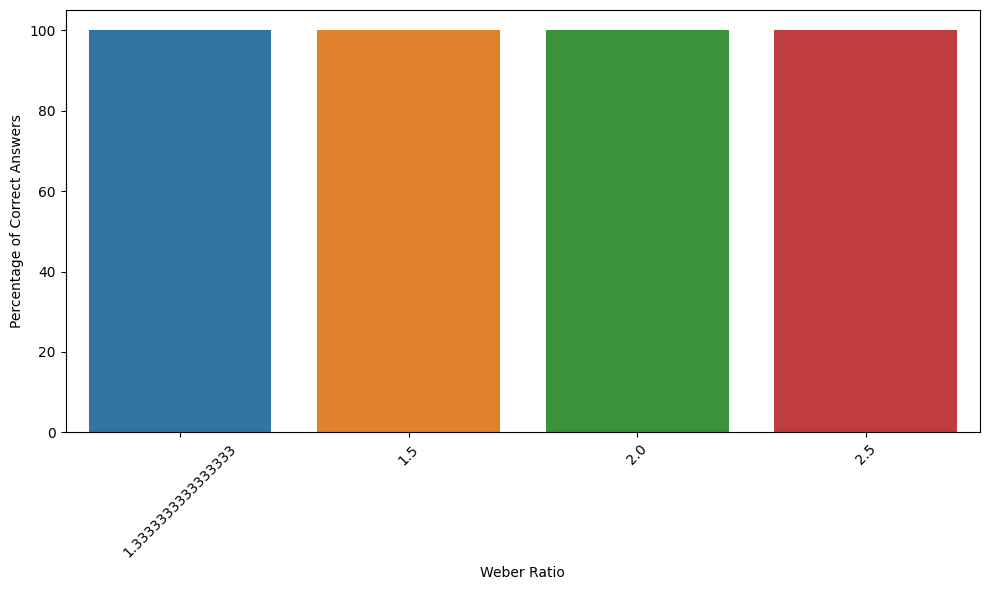

In [7]:
weber_plot = plot_weber_fraction(validation_results)

# Log validation metrics to wandb
if wandb_:
    wandb.log({
        'val_loss': running_loss / total,
        'val_accuracy': total_correct / total,
        "validation_results": wandb.Table(dataframe=validation_results),
        "Weber Fraction Plot": wandb.Image(weber_plot)
    })
    wandb.finish()
